# Imports

In [58]:
import matplotlib.pyplot as plt
from hypertiling import HyperbolicTiling, TilingKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.operators import adjacency
import networkx as nx
import numpy as np

# Create Hyperbolic Tiling Object

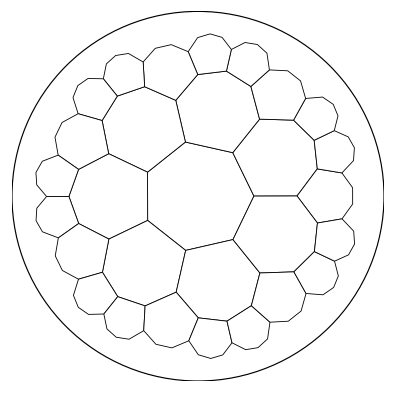

In [59]:
tiling = HyperbolicTiling(
    p=7, q=3, n=3,
    kernel=TilingKernels.StaticRotationalSector
)

plot_tiling(tiling, unitcircle=True, edgecolor="black", linewidth=0.5)
plt.show()

neighbors = tiling.get_nbrs_list(method="RO")

# Dual Graph and Spanning Tree

29


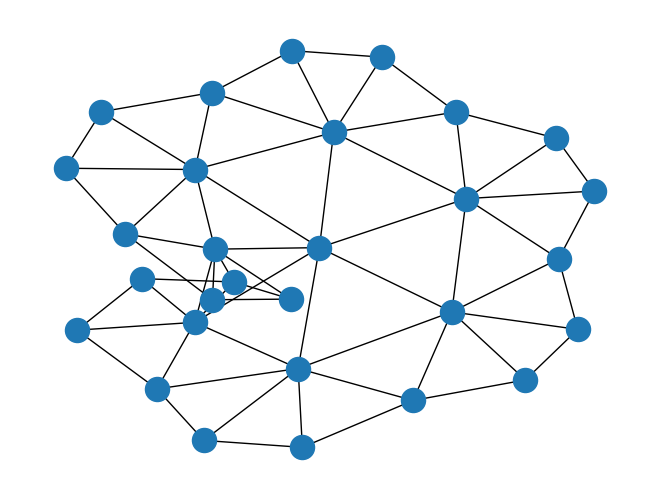

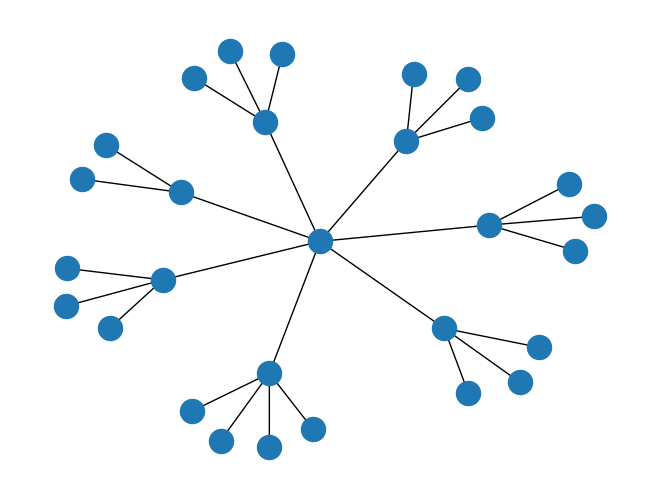

In [60]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
print(V)
G = nx.Graph()
for u, nbrs in enumerate(neighbors):
    for v in nbrs:
        if u < v:
            G.add_edge(u, v)
nx.draw(G)
plt.show()

# Get a spanning tree of G
T = nx.minimum_spanning_tree(G) 
nx.draw(T)
plt.show()
tree_edges = set(T.edges()) 


# Index Tiling Faces

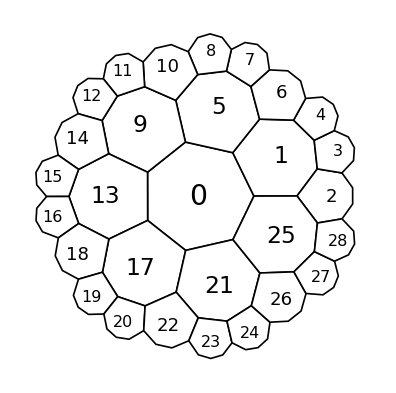

In [61]:
plot_tiling(tiling)
#layer_list = []
for poly in tiling.polygons:
    x, y = poly.get_center().real, poly.get_center().imag
    #layers = tiling.get_layer(poly)
    #layer_list.append(layers)
    plt.text(x, y, f"{poly.idx}", ha="center", va="center", fontsize=17*(1-0.7*np.abs(x*x+y*y)))
#print(layer_list)

# Notes

- need a way to make a list of each edge on the regular graph and find the intersections between the spanning tree 
- edges and the regular graph edges
- also need a way to take each face and find the regular graph edges that comprise the face cycle
- then we need to go back and figure out what multiplicities to assign to each spanning tree edge and also assign said multiplicity
- to the corresponding regular edge
- separately use coordinates to properly assign a sign -1 or +1 to each regular graph edge
- call this function within the multiplicity assigner for the regular graph and multiply with the sign
- call the multiplicities into the face cycles and then sum over everything + multiply by global phase
- this will be the total flux through the plaquette
- now check that this flux is equal to the global phase for each plaquette
- if correct, the adjacency matrix can be built and the butterfly should be accurate

# Extract Tiling Edges as a List

In [62]:
# First, we need to extract a list of edges for the regular tiling
edges = []
face_cycles = []
# iterate over cells
for poly in tiling:
    # extract vertex coordinates
    u = poly[1:]
    nv = len(u)
   
# loop over vertices/edges
    face_cycle_i = []
    for i in range(nv):
            # extract edges
            z1 = u[i]
            z2 = u[(i + 1) % 7]
            edge = (z1, z2)  
            face_cycle_i.append(edge)
    face_cycles.append(face_cycle_i)
    print((face_cycle_i))
#print((face_cycles))

#print(len(edges))
# this inherently uses the coordinates of each vertex - relate them to the indices i assigned for brevity
# these coordinates are also key for designating the +/- sign later 
# the length of each face cycle should be 7. 29 face cycles of 7 edges each for 203 edges total
# now I need to connect the edges contributing to each face cycle with the tuples based on the face index

[((0.3007419205951552+0.0006480178756849455j), (0.18700287970607574+0.23553353415610442j)), ((0.18700287970607574+0.23553353415610442j), (-0.06755314376524768+0.29305749520846863j)), ((-0.06755314376524768+0.29305749520846863j), (-0.27124027214833335+0.12990318508538537j)), ((-0.27124027214833335+0.12990318508538537j), (-0.270677943310499-0.13107087294905806j)), ((-0.270677943310499-0.13107087294905806j), (-0.0662896023360517-0.2933458902943042j)), ((-0.0662896023360517-0.2933458902943042j), (0.18801616125890078-0.23472546908228098j)), ((0.18801616125890078-0.23472546908228098j), (0.3007419205951552+0.0006480178756849455j))]
[((0.3007419205951552+0.0006480178756849455j), (0.5323811586257746+0.0011471380736834587j)), ((0.5323811586257746+0.0011471380736834587j), (0.6414738617025255+0.14786714794792635j)), ((0.6414738617025255+0.14786714794792635j), (0.6246124707519057+0.302457233105276j)), ((0.6246124707519057+0.302457233105276j), (0.513790827922822+0.4115487745482737j)), ((0.5137908279

# Match Spanning Tree Node Indices to that of Tiling Faces

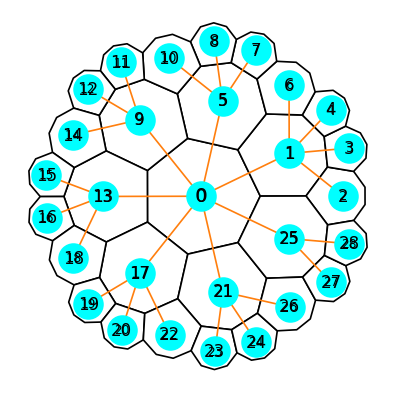

In [63]:
# Find a way to assign the vertices of the spanning tree the same index as the faces on the tiling 

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes
pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()


# Notes

In [124]:
# Now, I need to recursively define multiplicities associated with each edge of the spanning tree
# Then, I need to make sure that these multiplicities are associated with the right tiling edge
# After that, I need to pass that information into the face cycles so that I can obtain flux per plaquette

# Match Node/Face Indices to the Corresponding Layer of the Tiling 

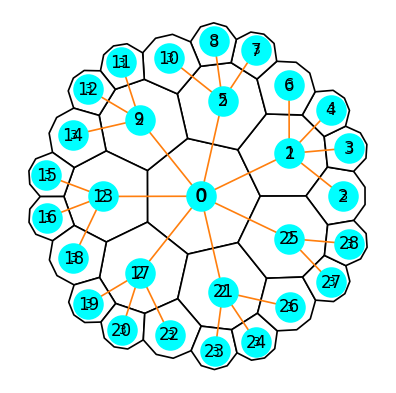

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28)]


In [64]:
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)


# Multiplicity Attempt 1

In [9]:
# consider every node from layer 3. each edge of ST with that node will have a multiplicity of 1. 
# since the idx of the node corresponds to the idx of the regular face, we then need to find the edge
# of the regular graph between the faces and assign that a multiplicity of 1

updated_layer_plus_poly = {}

for element in layer_plus_poly:
    if element[0] == 3:
        multiplicity = (1,)
        updated_layer_plus_poly[element] = element + multiplicity
    else:
        updated_layer_plus_poly[element] = element  # preserve others unchanged

# Print updated entries
for k, v in updated_layer_plus_poly.items():
    print(f"{k} -> {v}")


(0, 0) -> (0, 0)
(2, 1) -> (2, 1)
(3, 2) -> (3, 2, 1)
(3, 3) -> (3, 3, 1)
(3, 4) -> (3, 4, 1)
(2, 5) -> (2, 5)
(3, 6) -> (3, 6, 1)
(3, 7) -> (3, 7, 1)
(3, 8) -> (3, 8, 1)
(2, 9) -> (2, 9)
(3, 10) -> (3, 10, 1)
(3, 11) -> (3, 11, 1)
(3, 12) -> (3, 12, 1)
(2, 13) -> (2, 13)
(3, 14) -> (3, 14, 1)
(3, 15) -> (3, 15, 1)
(3, 16) -> (3, 16, 1)
(2, 17) -> (2, 17)
(3, 18) -> (3, 18, 1)
(3, 19) -> (3, 19, 1)
(3, 20) -> (3, 20, 1)
(2, 21) -> (2, 21)
(3, 22) -> (3, 22, 1)
(3, 23) -> (3, 23, 1)
(3, 24) -> (3, 24, 1)
(2, 25) -> (2, 25)
(3, 26) -> (3, 26, 1)
(3, 27) -> (3, 27, 1)
(3, 28) -> (3, 28, 1)


# Notes

In [145]:
# For each face cycle, we can describe the associated edges via the coordinates of the tiling's vertices
# We need to then find out the index of the two faces on either side of each of the face cycle edges
# For example, if E1 is an edge in the regular tiling and is part of the face cycle for both face 1 and face 3
# then I know that faces 1 and 3 are adjacent and there must exist an edge on the dual graph such that it is
# described by nodes 1 and 3 (ie. we pick out edge (1,3) or (3,1)). 
# this means we can correlate the tiling edges to dual graph edges within a list of tuples
# then iterate through each combination to build a new list that only contains tuples where the dual graph edge
# component is ALSO part of the spanning tree
# this new list will have tuples containing BOTH the edges of the spanning tree 
# and the edges of the tiling which they intersect with

# suppose we have another function that assigns a value to each spanning tree edge and multiplies it by phi
# now it would be easy to relate that information to the tiling edges by adding an element to the tuples
# each component of the list would now look like (tiling edge, ST edge, #phi)
# then somehow rebuild the face cycles including the #phi value
# sum over all #phi for each face cycle
# verify that the total matches for all face cycles
# build hamiltonian and butterfly

In [146]:
# since each tiling edge is written in terms of the coordinates of the vertices, 
# there should be a way to find the neighbors of each edge? - check package
# then, I should be able to figure out which faces are being glued together by each edge

# need a pandas data frame to store all this information because it's way too much stuff overall 

The information I need/have:

- list of the faces (their index)
- each face cycle
- list of the spanning tree nodes (indexed the same way as the faces)
- which layer each face belongs to
- the value associated with each spanning tree edge
- list of all the spanning tree edges
- list of all the dual graph edges (this information does not need to be stored permanently)


# Add Root to Spanning Tree

Graph with 30 nodes and 29 edges


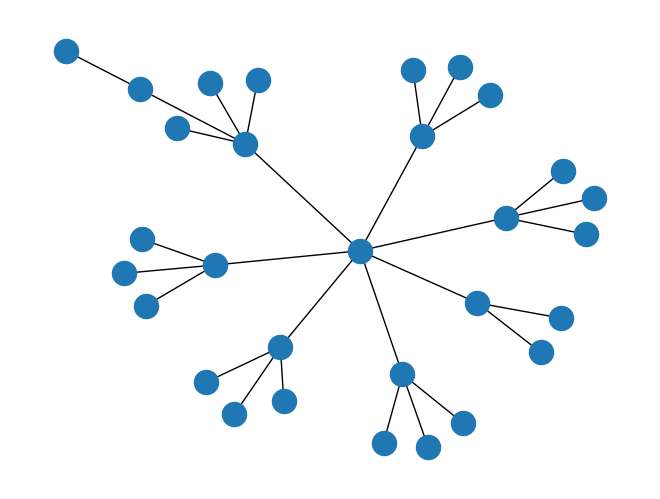

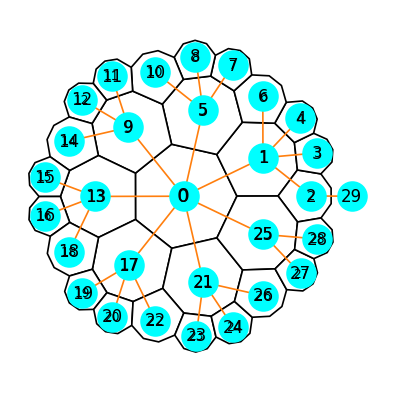

In [65]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
root_point = V

# p determines the number of edges each polygon face has, and every face will have p neighbors
# however, the faces on the outer ring will have p-1 neighbors, so if nbrs < p, said face is on the boundary
outermost_faces = []
for u, nbrs in enumerate(neighbors):
    if len(nbrs) < tiling.p:
        outermost_faces.append(u)
root_face = outermost_faces[0]

# Get a spanning tree of G
T_rooted = nx.minimum_spanning_tree(G)

T_rooted.add_edge(root_face, root_point)
tree_edges_rooted = set(T_rooted.edges()) 
print(T_rooted)
nx.draw(T_rooted)
plt.show()

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

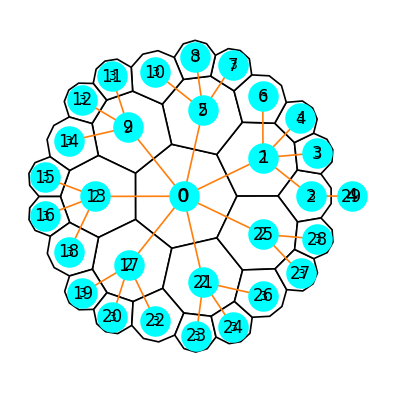

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28), (4, 29)]


In [66]:
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

outer_layer = tiling.n + 1
layers_list.append(outer_layer)
poly_list.append(root_point)

x, y = pos[root_point]
plt.text(x, y, str(outer_layer),
         ha="center", va="center",
         fontsize=12)

# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)

In [67]:
import pandas as pd

faces_nodes_layers_df = pd.DataFrame({
    "Tiling Faces/ST Nodes Index": poly_list,
    "Layer": layers_list
})

print(faces_nodes_layers_df)


    Tiling Faces/ST Nodes Index  Layer
0                             0      0
1                             1      2
2                             2      3
3                             3      3
4                             4      3
5                             5      2
6                             6      3
7                             7      3
8                             8      3
9                             9      2
10                           10      3
11                           11      3
12                           12      3
13                           13      2
14                           14      3
15                           15      3
16                           16      3
17                           17      2
18                           18      3
19                           19      3
20                           20      3
21                           21      2
22                           22      3
23                           23      3
24                       

In [69]:
print(tree_edges_rooted) # includes all the edges of the spanning tree + artificial root

node_to_layer = dict(zip(
    faces_nodes_layers_df["Tiling Faces/ST Nodes Index"],
    faces_nodes_layers_df["Layer"]
))

# relabel edges (u, v) → (layer(u), layer(v))
tree_edges_layers = [(node_to_layer[u], node_to_layer[v]) for (u, v) in tree_edges_rooted]
print(tree_edges_layers)

edges_df = pd.DataFrame(tree_edges_rooted, columns=["u", "v"])
edges_df["layer_u"] = edges_df["u"].map(node_to_layer).astype(int)
edges_df["layer_v"] = edges_df["v"].map(node_to_layer).astype(int)
print(edges_df)


{(5, 7), (5, 10), (0, 5), (9, 14), (9, 11), (1, 6), (1, 3), (0, 17), (25, 28), (2, 29), (21, 24), (0, 1), (1, 2), (17, 20), (0, 13), (13, 16), (0, 25), (25, 27), (21, 23), (21, 26), (5, 8), (9, 12), (0, 9), (17, 19), (1, 4), (17, 22), (0, 21), (13, 18), (13, 15)}
[(2, 3), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (3, 4), (2, 3), (0, 2), (2, 3), (2, 3), (0, 2), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (2, 3)]
     u   v  layer_u  layer_v
0    5   7        2        3
1    5  10        2        3
2    0   5        0        2
3    9  14        2        3
4    9  11        2        3
5    1   6        2        3
6    1   3        2        3
7    0  17        0        2
8   25  28        2        3
9    2  29        3        4
10  21  24        2        3
11   0   1        0        2
12   1   2        2        3
13  17  20        2        3
14   0  13        0        2
15  13  16        2        3
16   0  25

# Multiplicity Attempt 2

In [57]:
# ok now for the function assigning values to each spanning tree edge
multiplicities = []

root_layer = max(edges_df["layer_v"])
outer_layer = root_layer - 1

if i in edges_df["layer_v"] == root_layer:
    # find edges_df["u"] in the same row of the df - this is the tiling face connected to the root
    # skip assigning multiplicities to any (u,v) where either u or v are this tiling face

if i in edges_df["layer_v"] == outer_layer:
    multiplicity_of_edge = 1  # the edge (u,v) corresponding to (layer_u, outer_layer) is assigned this value

if i in edges_df["layer_v"] == outer_layer - 1:
    # find edges_df["v"] associated with this and then find all edges (u,v) such that the u is the same as the edges_df["v"]
    # then consider the multiplicity_of_edge values associated with that row of the df and sum them 
    multiplicity_of_edge = sum()

IndentationError: expected an indented block (632898222.py, line 11)

In [ ]:

def assign_edge_multiplicities_shallow(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy()

    root_layer  = int(df["layer_v"].max())
    outer_layer = root_layer - 1

    # faces directly connected to the root
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy()))
    multiplicity = {}

    # Base: edges whose parent is on outer_layer → multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]]
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # Children index: edges grouped by their CHILD (u)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # One step inward: parent at (outer_layer - 1)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_cur = row["v"]
        kids = child_index.get(v_cur, [])      # edges with u == v_cur (the outward children)
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]]

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        m_root = v_root
        multiplicity[e_root] = m_root

        # the edge whose parent equals this u (v == u0): multiplicity = m_root - 1
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            # In a tree there should be at most one; if multiple, take the first
            e_child = child_rows.iloc[0]["edge"]
            # Only set if not already set; if set, overwrite per your rule
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root

    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    return df.drop(columns=["edge"])

edges_with_mult = assign_edge_multiplicities_shallow(edges_df)
multiplicities = edges_with_mult["multiplicity"].tolist()
print(edges_with_mult)
print(multiplicities)

     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2             4
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1
20   5   8        2        3             1
21   9  12        2        3             1
22   0   9 

In [ ]:
def assign_edge_multiplicities_shallow(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy()

    root_layer  = int(df["layer_v"].max())
    outer_layer = root_layer - 1

    # faces directly connected to the root
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy()))
    multiplicity = {}

    # Base: edges whose parent is on outer_layer → multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]]
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # Children index: edges grouped by their CHILD (u)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # One step inward: parent at (outer_layer - 1)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_cur = row["v"]
        kids = child_index.get(v_cur, [])      # edges with u == v_cur (the outward children)
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]]

    # --- NEW: collect grandchildren for each root-layer edge (kept in df.attrs) ---
    grandchildren_by_root_edge = {}
    grandchildren_by_child_edge = {}
    # ------------------------------------------------------------------------------

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        m_root = v_root
        multiplicity[e_root] = m_root

        # the edge whose parent equals this u (v == u0): multiplicity = m_root - 1
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            # In a tree there should be at most one; if multiple, take the first
            e_child = child_rows.iloc[0]["edge"]
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root

            # --- NEW: grandchildren of that chosen child edge (two steps from root) ---
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges
            # --------------------------------------------------------------------------

    # --- NEW: store results without changing return columns ---
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge
    # ----------------------------------------------------------

    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    return df.drop(columns=["edge"])

edges_with_mult = assign_edge_multiplicities_shallow(edges_df)

# All grandchildren (list of edges) per root-layer edge:
gc_by_root = edges_with_mult.attrs["grandchildren_by_root_edge"]

# Or keyed by the chosen child edge (the one used in your loop):
gc_by_child = edges_with_mult.attrs["grandchildren_by_child_edge"]

print(edges_with_mult)
print(gc_by_root)
print(gc_by_child)

     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2             4
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1
20   5   8        2        3             1
21   9  12        2        3             1
22   0   9 

# Successful Multiplicity Assigner

In [71]:
def assign_edge_multiplicities(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy() # the data frame contains the ST edges in terms of face indices and their tiling layer
    # each edge's data is contained in a row in this df - aim is to add the multiplicity value associated with every edge
    # to the df - this value represents the number of times the ST edge crosses its corresponding tiling edge
    # and will eventually be ascribed to that tiling edge
    root_layer  = int(df["layer_v"].max()) # when I added the artificial root, I assigned this node a tiling layer of
    # value n + 1 where n is the layer of the edge tiles (hence the next line)
    # for this line, I just pulled the maximum value of the tiling layers from the df since that has to be the root layer
    outer_layer = root_layer - 1

    # first, I want to start from the outer layer and go to the next layer. in doing so, I will traverse ST edges, and 
    # I know for a fact that all of these edges should be ascribed a multiplicity of 1
    # however, there is a chain of faces and ST edges that connects from the root layer to the center tile
    # I want to exclude assigning a multiplicity of 1 to the outer tile to next layer ST edge where the 
    # outer tile is connected to the root node, because that would be annoying to correct later
    # thus, I exclude the face directly connected to the root during this first round assignment
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy())) # from df, extract edges as tuples for ease
    multiplicity = {} # empty dict for multiplicities to be added to df later

    # the hierarchy is: root_edge (not really part of the ST), parent edges (edges from outer faces to the next layer)
    # then children edges (in (u,v), u is the child, and the child edge is (u',v') st. v' = u) 
    # the "parent" is the v in (u,v) since it defines the layer (layer_u, layer_v) from which the edge goes further into the tiling

    # Round 1 - Base: edges whose parent is on outer_layer given multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]] # define edges that will be given multiplicity = 1
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # define edges grouped by the children of the base edge parents (we had (u,v) given 1, and now we want to find 
    # all the edges (u',v' = u) since they are children edges going from layer n to n-1)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # Round 2 - one step inward: parent at (outer_layer - 1) (u is now the parent)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_current = row["v"]
        children = child_index.get(v_current, [])      # edges with u == v_current 
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in children) + 1
        # I need to sum the multiplicities of the previous base edges associated with u to get the multiplicity
        # of the edge who's parent  is u

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]] # all the data tracing back to root

    # grandchildren from the root are the children of the parent edge
    # grandchildren from the child edge are in the case of the tiling im using, the last layer of edges
    grandchildren_by_root_edge = {} 
    grandchildren_by_child_edge = {}

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        # basically, now I am assigning a multiplicity to the root edge and I know it should be equal to the number of faces
        # so since I made the index of the root node 1 + the highest, and python iterates from zero, it's index value should be
        # exactly the multiplicity it needs to be assigned
        m_root = v_root
        multiplicity[e_root] = m_root
        # now I want to go to the next edge connected to the root edge and assign it's multiplicity as  +(-1) of the previous
        # the edge whose parent equals this u (v == u0) has multiplicity = m_root - 1
        # I grab this edge by just finding which child edge I have not yet assigned a multiplicity to yet
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            e_child = child_rows.iloc[0]["edge"] # ^that edge
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root # just for safety

            # grandchildren (two steps from root)
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges

    # finalize multiplicities - make sure the sums update since all the multiplicities are filled now
    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    # in particular, the grandchild of the root has a value from the sums, but it is not accurate since
    # we hadn't assigned the root or root child multiplicities before - gotta update this as -sum + root child
    # overwrite the single grandchild multiplicity using the child edge multiplicity
    try:
        gc_root_flat = [e for lst in grandchildren_by_root_edge.values() for e in lst]
        gc_child_flat = [e for lst in grandchildren_by_child_edge.values() for e in lst]
        if len(gc_root_flat) == 1 and gc_root_flat == gc_child_flat:
            gc_edge = gc_root_flat[0]

            # find the unique child edge associated with this grandchild
            child_candidates = [ec for ec, lst in grandchildren_by_child_edge.items() if gc_edge in lst]
            if child_candidates:
                e_child_edge = child_candidates[0]

                # original grandchild multiplicity X
                u_gc, v_gc = gc_edge
                m_gc_old = int(df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"].iloc[0])

                # child edge multiplicity
                u_ch, v_ch = e_child_edge
                m_child = int(df.loc[(df["u"] == u_ch) & (df["v"] == v_ch), "multiplicity"].iloc[0])

                # overwrite new_multiplicity = -(X) + m_child
                new_m = int(-m_gc_old + m_child)

                # apply to df
                df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"] = new_m
                multiplicity[gc_edge] = new_m
                # check to see if it worked
                print(
                    f"Grandchild edge {gc_edge} multiplicity updated: "
                    f"old={m_gc_old}, child edge {e_child_edge} had multiplicity={m_child}, new={new_m}"
                )
    except Exception:
        pass # safety

    # keep grandchildren 2 ways as a consistency check - not included in final df
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge

    return df.drop(columns=["edge"])
edges_with_mult = assign_edge_multiplicities(edges_df)
print(edges_with_mult)

Grandchild edge (0, 1) multiplicity updated: old=4, child edge (1, 2) had multiplicity=28, new=24
     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2            24
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1